# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [2]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [3]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [4]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [5]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [6]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [7]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [8]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [9]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        if scheduler is not None:
            scheduler.step(ave_loss)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for i_step, (x, y) in enumerate(loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = torch.argmax(model(x_gpu), 1)
            for i in range(len(prediction)):
                if prediction[i] == y_gpu[i]:
                    correct += 1
            total += len(prediction)

    return float(correct / total)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.416767, Train accuracy: 0.524417, Val accuracy: 0.768207
Average loss: 0.678853, Train accuracy: 0.795482, Val accuracy: 0.810115
Average loss: 0.578624, Train accuracy: 0.827458, Val accuracy: 0.796260
Average loss: 0.536145, Train accuracy: 0.841347, Val accuracy: 0.818920
Average loss: 0.501530, Train accuracy: 0.852950, Val accuracy: 0.827589


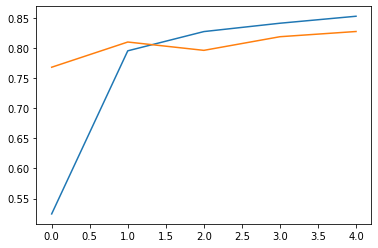

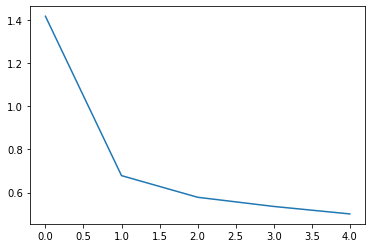

In [10]:
plt.plot(train_history)
plt.plot(val_history)
plt.show()
plt.plot(loss_history)

# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [13]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


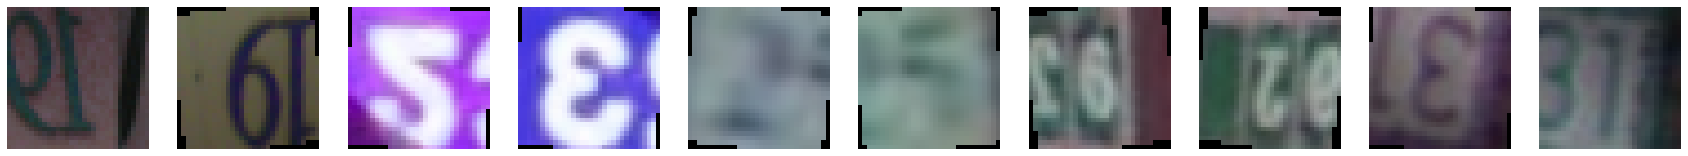

In [35]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [12]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug = dset.SVHN('./', 
                       transform=tfs
                      )

# TODO create new instances of loaders with the augmentations you chose
train_aug_loader = train_aug_loader = torch.utils.data.DataLoader(data_aug, batch_size=batch_size, 
                                           sampler=train_sampler)

c:\virtualenv\lib\site-packages\torchvision\transforms\transforms.py:1292: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  warnings.warn(


In [37]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.610288, Train accuracy: 0.813825, Val accuracy: 0.822401
Average loss: 0.561487, Train accuracy: 0.829488, Val accuracy: 0.851341
Average loss: 0.543045, Train accuracy: 0.835000, Val accuracy: 0.846905
Average loss: 0.525636, Train accuracy: 0.840716, Val accuracy: 0.831138
Average loss: 0.513857, Train accuracy: 0.843924, Val accuracy: 0.833936


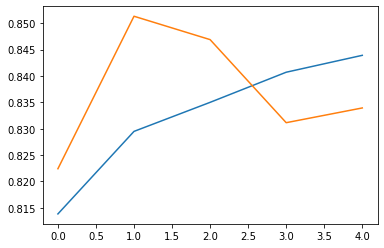

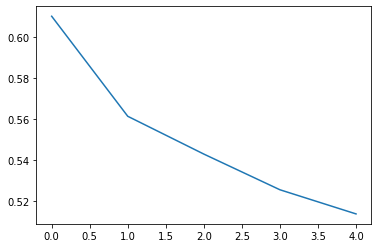

In [38]:
plt.plot(train_history)
plt.plot(val_history)
plt.show()
plt.plot(loss_history)

# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [39]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
  nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
  nn.ReLU(),
  nn.MaxPool2d(kernel_size=2, stride=2),
  nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
  nn.ReLU(),
  nn.MaxPool2d(kernel_size=2, stride=2), 
  nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
  nn.ReLU(),
  Flattener(),
  nn.ReLU(),
  nn.Linear(in_features=120, out_features=84),
  nn.ReLU(),
  nn.Linear(in_features=84, out_features=10),
)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [40]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.515749, Train accuracy: 0.480650, Val accuracy: 0.806498
Average loss: 0.595215, Train accuracy: 0.823465, Val accuracy: 0.845540
Average loss: 0.479458, Train accuracy: 0.857455, Val accuracy: 0.874548
Average loss: 0.423351, Train accuracy: 0.874126, Val accuracy: 0.879735
Average loss: 0.383741, Train accuracy: 0.884346, Val accuracy: 0.892704
Average loss: 0.358880, Train accuracy: 0.892349, Val accuracy: 0.899393
Average loss: 0.336427, Train accuracy: 0.898713, Val accuracy: 0.897208
Average loss: 0.317887, Train accuracy: 0.905232, Val accuracy: 0.895775
Average loss: 0.308699, Train accuracy: 0.906904, Val accuracy: 0.897754
Average loss: 0.297130, Train accuracy: 0.910368, Val accuracy: 0.889564


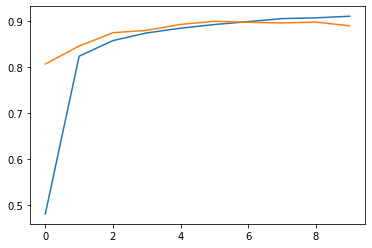

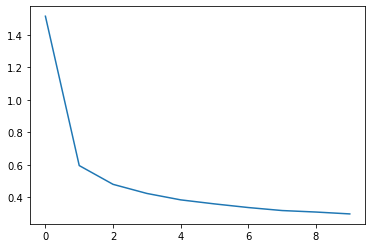

In [41]:
plt.plot(train_history)
plt.plot(val_history)
plt.show()
plt.plot(loss_history)

# Подбор гиперпараметров

In [13]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [2, 5]
reg = [1e-3, 1e-5]

batch_size = 64
epoch_num = 5

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!
best_accuracy = 0
for learnRate in learning_rates:
    for regStr in reg:
        print("Learing rate: ", learnRate, "; RegStr: ", regStr)
        model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0),
        nn.MaxPool2d(kernel_size=2),
        
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
        nn.MaxPool2d(kernel_size=2),
    
        Flattener(),
        nn.Linear(in_features=16*5*5, out_features=120),
        nn.BatchNorm1d(120),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=120, out_features=84),
        nn.BatchNorm1d(84),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=84, out_features=10),
        )
        model.type(torch.cuda.FloatTensor)
        model.to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=learnRate, weight_decay=regStr)
        sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose=True)
        
        loss_history, train_history, val_history = train_model(model, train_aug_loader, val_loader, 
                                                               loss, optimizer,epoch_num, sheduler)
        if val_history[-1] > best_accuracy:
            best_model = model
    
        run_record[Hyperparams(learnRate, regStr)] = RunResult(model, train_history, val_history , val_history[-1])

Learing rate:  0.01 ; RegStr:  0.001
Average loss: 0.973386, Train accuracy: 0.684128, Val accuracy: 0.803017
Average loss: 0.717778, Train accuracy: 0.774887, Val accuracy: 0.814961
Average loss: 0.692019, Train accuracy: 0.783708, Val accuracy: 0.823835
Average loss: 0.674928, Train accuracy: 0.790670, Val accuracy: 0.807453
Average loss: 0.672181, Train accuracy: 0.791694, Val accuracy: 0.823562
Learing rate:  0.01 ; RegStr:  1e-05
Average loss: 0.966046, Train accuracy: 0.682541, Val accuracy: 0.839874
Average loss: 0.554003, Train accuracy: 0.827765, Val accuracy: 0.861102
Average loss: 0.501869, Train accuracy: 0.844214, Val accuracy: 0.869975
Average loss: 0.472855, Train accuracy: 0.852626, Val accuracy: 0.873729
Average loss: 0.456642, Train accuracy: 0.856977, Val accuracy: 0.884445
Learing rate:  0.001 ; RegStr:  0.001
Average loss: 0.852376, Train accuracy: 0.737860, Val accuracy: 0.852365
Average loss: 0.539494, Train accuracy: 0.834130, Val accuracy: 0.862262
Average loss

In [14]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.88, best hyperparams: Hyperparams(learning_rate=0.01, reg=1e-05)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [15]:
best_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=7, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            Flattener(),
            nn.Linear(in_features=256, out_features=120),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(120),
            nn.Linear(in_features=120, out_features=10),
          )
best_model.type(torch.cuda.FloatTensor)
best_model.to(device)
optimizer = optim.Adam(best_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose= False)

loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer, 20, scheduler)

Average loss: 0.663983, Train accuracy: 0.790772, Val accuracy: 0.880622
Average loss: 0.385408, Train accuracy: 0.882094, Val accuracy: 0.901304
Average loss: 0.315320, Train accuracy: 0.903286, Val accuracy: 0.906218
Average loss: 0.270525, Train accuracy: 0.918848, Val accuracy: 0.913931
Average loss: 0.238172, Train accuracy: 0.927055, Val accuracy: 0.914818
Average loss: 0.205818, Train accuracy: 0.937020, Val accuracy: 0.920415
Average loss: 0.180655, Train accuracy: 0.944101, Val accuracy: 0.919391
Average loss: 0.164037, Train accuracy: 0.949357, Val accuracy: 0.920278
Average loss: 0.144235, Train accuracy: 0.953622, Val accuracy: 0.918913
Average loss: 0.129317, Train accuracy: 0.958793, Val accuracy: 0.916729
Average loss: 0.115747, Train accuracy: 0.962854, Val accuracy: 0.911678
Average loss: 0.109029, Train accuracy: 0.964543, Val accuracy: 0.919186
Average loss: 0.097286, Train accuracy: 0.968075, Val accuracy: 0.920551
Average loss: 0.095710, Train accuracy: 0.968314, V

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [16]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9169099569760295
